In [4]:
%load_ext autoreload
%autoreload 2
import sys
import os
from Tissue_Objects import *
from CommonOperations import *
    
def write_cell_edges(T):
    for c in T.ListCell:
        print(c.area)
        if c.crossBdry:
            continue
        tail_edges = []
        dl_edges = []
        for E in c.ListEdges:
            e = E[0]
            tail_edges.append([e.tailVertex.coord.x, e.tailVertex.coord.y])
            dl_edges.append([e.dl.x, e.dl.y])
            image_name = 'cells/'+str(c.Number)+'.png'
            plot_cell_edges(tail_edges, dl_edges, image_name)
            
if not os.path.exists("data"):
    os.makedirs("data")
if not os.path.exists("images"):
    os.makedirs("images")

#if len(sys.argv)==1:
#    print("Please provide an input file.")
#    exit(1)

def visulaise_frames(n_steps, skip, color_type):
    for i in np.arange(0,int(n_steps+1), skip):
        data_name = "data/T"+str(i)+".json"
        image_name = "images/t"+str(i).zfill(5)+".png"
        visualize_frame_jsonfile(data_name, image_name, color_type)

def run_simulation(Nx, Ny, Ta, Kc, A0c, Gc, sim_type, n_steps, dt, inserting_gamma):
    """
    First a regular hexagonal tissue with given arguments is creatred.
    Next: it runs for 1000 steps to move tissue near force balance,
    before I start the actual simulation mode, which is given as "sim_type".
    """
    
    if not os.path.exists(str(inserting_gamma)+"/data"):
        os.makedirs(str(inserting_gamma)+"/data")
    if not os.path.exists(str(inserting_gamma)+"/images"):
        os.makedirs(str(inserting_gamma)+"/images")
    
    
    T = Tissue(Ta, Kc, A0c, Gc)   
    
    if sim_type=='edge_collapse':
        T.build_tissue_from_file("data/T_final.json")
        
        delta_gamma = 0.2 * T.Ta
        el_ratio = []
        e_lengths = []
        e_tensions = []
        for i in range(len(T.ListEdge)):
            T.is_with_T1_trans = False
            e = T.ListEdge[i]
            e.get_dl()
            e_i = e.length
            e_lengths.append(e_i)
            e_tensions.append(e.lineTension)
            e.lineTension = e.lineTension + delta_gamma
            T.minimize_dynamically(2000, 0.1, 0, False, False)
            e.get_dl()
            e_f = e.length
            print(i, e_i, e_f, e_f/e_i)
            el_ratio.append(e_f/e_i)
            T.build_tissue_from_file("data/T_final.json")
        np.savetxt("nbrun/edges_collapse.txt", el_ratio, fmt="%.3f")
        np.savetxt("nbrun/edges_lengths.txt", e_lengths, fmt="%.3f")
        np.savetxt("nbrun/edges_tensions.txt", e_tensions, fmt="%.3f")
        return T, []
        
    T.create_hexagonal_tissue(Nx, Ny, Kc, A0c, Ta, Gc)
    T.update_derivatives_analytically()

    write_freq = 100
    T.minimize_dynamically(500, 0.1, 0, False, False)

    delta = 0.01*np.sqrt(T.A0c) # opening length of edge
    W_steps = []

    if sim_type=='4fold':
        v_cent = T.find_vertex_at_center()
        shrinking_edge = v_cent.connectedEdges[0]
        T.shrink_edge_to_vertex(shrinking_edge)
        T.minimize_dynamically(2000, 0.1, write_freq, False, False)
        for v in T.ListVertex:
            if len(v.connectedEdges)==4:
                T.open_vertex_to_cell(v, inserting_gamma)
        W_steps = T.minimize_dynamically(n_steps, dt, write_freq, True, True)

    elif sim_type=='3fold':
        v_cent = T.find_vertex_at_center()
        T.open_vertex_to_cell(v_cent, inserting_gamma)
        W_steps = T.minimize_dynamically(n_steps, dt, write_freq, True, True)

    elif sim_type=='both_sides':
        v_cent = T.find_vertex_at_center()
        e = v_cent.connectedEdges[0]
        T.open_vertex_to_cell(e.tailVertex, inserting_gamma)
        T.open_vertex_to_cell(e.headVertex, inserting_gamma)
        W_steps = T.minimize_dynamically(n_steps, dt, write_freq, True, True)

    elif sim_type=='randomized_packing':
        for i in range(10):
            n_e = len(T.ListEdge)
            eid = random.randrange(n_e)
            e = T.ListEdge[eid]

            if e.crossBdry or e.c1.crossBdry or e.c2.crossBdry:
                continue
            if len(e.c1.ListEdges)>4 and len(e.c2.ListEdges)>4:
                T.shrink_edge_to_vertex(e)
            #T.shrink_random_edge()
        for v in T.ListVertex:
            dr = Point(random.uniform(-1.0,1.0), random.uniform(-1.0,1.0), 0)
            v.coord = v.coord +dr.X(0.05)
        W_steps = T.minimize_dynamically(n_steps, dt, write_freq, True, True)

    elif sim_type=='quadruple':
        v_cent = T.find_vertex_at_center()
        shrinking_edge = v_cent.connectedEdges[0]
        T.flip_edge(shrinking_edge)
        W_steps = T.minimize_dynamically(n_steps, dt, write_freq, True, True)
        
    elif sim_type=='randomized_tension':
        for i in range(int(0.2*len(T.ListEdge))):
            n_e = len(T.ListEdge)
            eid = random.randrange(n_e)
            e = T.ListEdge[eid]
            tx, ty = e.tailVertex.coord.x, e.tailVertex.coord.y
            if is_point_near_bdr(tx, ty, T.SystemSize.x, T.SystemSize.y):
                continue

            if e.crossBdry or e.c1.crossBdry or e.c2.crossBdry:
                continue
            if len(e.c1.ListEdges)>4 and len(e.c2.ListEdges)>4:
                T.flip_edge(e)
        T.minimize_dynamically(10000, dt, write_freq, False, False)
        gamma_mean = T.Ta
        gamma_std = T.Ta/4.0
        Tvalues = np.random.normal(gamma_mean, gamma_std, len(T.ListEdge))
        for i in range(len(Tvalues)):
            if T.ListEdge[i].c1.crossBdry or T.ListEdge[i].c2.crossBdry:
                continue
            T.ListEdge[i].lineTension = Tvalues[i]
        W_steps = T.minimize_dynamically(n_steps, dt, write_freq, True, True)
        
    elif sim_type=='probing_vertices':
        for i in range(int(0.15*len(T.ListEdge))):
            n_e = len(T.ListEdge)
            eid = random.randrange(n_e)
            e = T.ListEdge[eid]
            tx, ty = e.tailVertex.coord.x, e.tailVertex.coord.y
            if is_point_near_bdr(tx, ty, T.SystemSize.x, T.SystemSize.y):
                continue

            if e.crossBdry or e.c1.crossBdry or e.c2.crossBdry:
                continue
            if len(e.c1.ListEdges)>4 and len(e.c2.ListEdges)>4:
                T.flip_edge(e)
        T.minimize_dynamically(1000, dt, write_freq, False, False)
        gamma_mean = T.Ta
        gamma_std = T.Ta/5.0
        Tvalues = np.random.normal(gamma_mean, gamma_std, len(T.ListEdge))
        for i in range(len(Tvalues)):
            if T.ListEdge[i].c1.crossBdry or T.ListEdge[i].c2.crossBdry:
                continue
            T.ListEdge[i].lineTension = Tvalues[i]
        W_steps = T.minimize_dynamically(10000, dt, write_freq, True, True)
        
        old_coords = []
        for v in T.ListVertex:
            old_coords.append(v.coord)
            
        print("number of vertices: "+str(len(T.ListVertex)))
        for v in T.ListVertex:
            T.probe_vertex(v, 500, old_coords)
            prt_str = "vertex id: "+str(v.storing_order)+", k_d="+"{:.3f}".format(v.probing_k)
            prt_str = prt_str + ", polyclass of neighb cells: "
            for cor in v.ListCorners:
                prt_str = prt_str + str(len(cor.c.ListEdges))+" "
            print(prt_str)
        T.write_tissue_to_file('data/T_final.json', True)
        datafile = 'data/T_final.json'
        color_type = 'dW_dh'
        image_name = 'gamma'+str(Ta)+color_type+'.pdf'
        visualize_frame_jsonfile(datafile, image_name, color_type)
        color_type = 'probing'
        image_name = 'gamma'+str(Ta)+color_type+'.pdf'
        visualize_frame_jsonfile(datafile, image_name, color_type)

        color_type = 'd2W_dv2'
        image_name = 'gamma'+str(Ta)+color_type+'.pdf'
        visualize_frame_jsonfile(datafile, image_name, color_type)
        visulaise_frames(n_steps, write_freq, color_type)
    elif sim_type=='check_vertex_opening':     
        #now we check the vertex opening
        print("number of vertices: "+str(len(T.ListVertex)))
        area_opening = []
        T.build_tissue_from_file("data/T_final.json")
        for vid in range(len(T.ListVertex)):
            v = T.ListVertex[vid]
            prt_str = "vertex id: "+str(v.storing_order)
            prt_str = prt_str + ", polyclass of neighb cells: "
            for cor in v.ListCorners:
                prt_str = prt_str + str(len(cor.c.ListEdges))+" "
            
            T.check_vertex_opening(v, 1000, inserting_gamma)
            prt_str = prt_str +", a_f="+"{:.3f}".format(v.final_opening_area)
            print(prt_str)
            area_opening.append(v.final_opening_area)
            T.build_tissue_from_file("data/T_final.json")
            
        for iv in range(len(T.ListVertex)):
            T.ListVertex[iv].final_opening_area = area_opening[iv]
           
        T.write_tissue_to_file(str(inserting_gamma)+'/data/rebuilt_T_final.json', True)
        datafile = str(inserting_gamma)+'/data/rebuilt_T_final.json'
        color_type = 'opening_area'
        image_name = str(inserting_gamma)+'/images/inserting_gamma'+str(inserting_gamma)+color_type+'.pdf'
        make_histogram_plots(str(inserting_gamma)+'/data/', str(inserting_gamma)+'/images/')
        #visualize_frame_jsonfile(datafile, image_name, color_type
            
    return T, W_steps
#===========================================================
Nxy = 8
#Ta (or \gamma): line tension
gamma, Kc, A0c, Gc = 0.02, 1.0, 1.0, 0
inserting_gamma = 0.02
#sim_type = 'randomized_packing'

#sim_type = 'probing_vertices'
#sim_type = 'build_from_file'
sim_type = 'edge_collapse'
#sim_type = 'check_vertex_opening'

n_steps, dt = 2000, 0.1

T, W_steps = run_simulation(Nxy, Nxy, gamma, Kc, A0c, Gc, sim_type, n_steps, dt, inserting_gamma)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0 0.5481824974321229 0.40923747200544913 0.7465350935545362
1 0.7178611993550441 0.590649537848369 0.8227907266460881
2 0.531263472222471 0.3972415062846978 0.7477297556763881
3 0.6458704269622061 0.5136722628513694 0.7953178244549468
4 0.5689845063880556 0.4324592206698195 0.7600544756747314
5 0.7201149832802433 0.5924381325682134 0.8226993554134361
6 0.714908142997767 0.581890028647113 0.8139367754395974
7 0.5518251170846261 0.4055488465813299 0.7349227753964962
8 0.5684689312001235 0.42821722765042386 0.7532816731890568
9 0.5063627786731114 0.3555014653170041 0.7020687149410371
10 0.8774874455491144 0.7490062272501197 0.8535805623764865
11 0.5711763150852728 0.4283362422394848 0.7499194748219506
12 0.6181050656088842 0.4854892897366883 0.7854478417167501
13 0.6815242455157714 0.5556743070434413 0.8153404823080241
14 0.6961986814350177 0.5736326504080933 0.8239496363677549
15 0.6125351037339082 0.

135 0.7983536722223189 0.6533191481653973 0.8183329906240682
136 0.5890862312324878 0.44352415310824056 0.7529019175686692
137 0.7467379928096416 0.6240997348989348 0.8357680215931242
138 0.361589536930913 0.2158910521177124 0.5970611150702669
139 0.8170920445296135 0.6391465534431559 0.78222099667009
140 0.44966686540699535 0.25627271162733806 0.5699168236365038
141 0.4998218202999326 0.35652049274636677 0.7132951749333918
142 0.7220248876223434 0.5775242753576443 0.799867546476763
143 0.7423287701469482 0.6041733421361241 0.8138891639839373
144 0.49305399235808245 0.35440845886373357 0.718802533509034
145 0.6593748226980745 0.5169798619244467 0.7840454990517132
146 0.690762416241679 0.5613904408052226 0.8127113282445977
147 0.6407879149299381 0.5080195156917595 0.792804458160396
148 0.7015149185827181 0.5619651086601122 0.8010736390260372
149 0.6327122377432406 0.49473832413187624 0.7819325984534612
150 0.7154560521550788 0.5777730146879294 0.8075590568387478
151 0.43051292380579337 

270 0.7674972728714692 0.5453923499515518 0.7106114500069205
271 0.8665637506972736 0.6945912539843333 0.8015466299224216
272 0.7791878228877609 0.678041904847898 0.8701905816944053
273 0.7274481596363559 0.5927898094846094 0.8148894208227004
274 0.6777777694347149 0.563352880169836 0.8311763908097599
275 0.5406786104647969 0.42688220287132955 0.789530406065737
276 0.3490204703065184 0.13688777541222294 0.39220557834904274
277 0.8958176482414567 0.7472842342176379 0.8341923556480509
278 1.5091162960382487 1.4125600301237426 0.9360180085736356
279 1.1193580962880563 1.0133251319453287 0.9052734199231262
280 0.6612227020672581 0.5157758103053047 0.7800334270023916
281 0.5549925070277223 0.4446990270216513 0.8012703259783618
282 0.7167724437296663 0.5927681448326552 0.8269962803651254
283 0.650839490448468 0.5165945843735904 0.7937357704241722
284 0.5479347678116724 0.41683052272210497 0.760730194922348
285 0.4837479340649142 0.3358866775049092 0.6943423503279221
286 0.7053540010928196 0.

404 0.889878806773444 0.7767484824741224 0.8728699644960489
405 0.8871928909228417 0.7649794174918563 0.8622470100004281
406 0.773870613079917 0.6310845397392256 0.8154910253376607
407 0.5212063314706894 0.34688540901957776 0.6655433521706657
408 0.41626204990131926 0.24488325152183044 0.5882910814951385
409 0.5464992917903189 0.4160467189313972 0.761294159354604
410 0.6120374935839191 0.45550134597825154 0.7442376500677499
411 0.781509681454359 0.624450115287529 0.799030555994459
412 0.44227488773574375 0.27567991775438516 0.6233225656689376
413 0.8120048756146714 0.6645984816230499 0.8184661220414006
414 0.4054727250358892 0.20909434952743777 0.5156804308080905
415 0.3504821917003902 0.02697063952083745 0.07695295270206856
416 0.8552501667339188 0.7050662061769364 0.824397624930593
417 0.3806521663909316 0.182831077976005 0.4803100944084385
418 0.9952965898232392 0.882309953618377 0.8864794299908852
419 0.7030131391738546 0.5360718890849916 0.7625346657317901
420 0.4103068944202815 0

539 0.17498975260479507 0.014573022462660817 0.08327929061979535
540 0.5440993885268801 0.409846533354249 0.7532567431547506
541 0.6810263714184522 0.5369477158109803 0.7884389479553007
542 0.28563737651204424 0.11299412755621252 0.39558593114108087
543 0.8822821234945727 0.7688102244816507 0.8713881920632386
544 0.9749386316482678 0.8542728826074162 0.876232467230425
545 0.4592705379016644 0.2942506493482761 0.6406913247530781
546 0.7115172309207214 0.5782778014968711 0.8127389982510542
547 0.39652472209405853 0.22871707296368643 0.5768040684974822
548 0.4277889333738247 0.2820637312598479 0.659352566779388
549 0.7228828825618016 0.5705577224602675 0.7892809972734258
550 1.3469035529004625 1.2432952681248854 0.9230766861127778
551 0.23787128508371383 0.02170999746503572 0.09126783612151984
552 0.9221914299861474 0.8118044502337228 0.8802992782593059
553 0.7734045292988193 0.64775774101728 0.8375406614240382
554 1.139077807517198 1.021626462752055 0.896889093975813
555 0.71490336194659

673 0.6360369320104583 0.504428792103131 0.7930809780316919
674 0.907221758278228 0.7751901419561923 0.854465994540726
675 0.43002954035299523 0.26495686689919296 0.61613643258484
676 0.5554497069664915 0.39034159299031923 0.7027487603191179
677 0.5409897223522956 0.3725179291844828 0.6885859634536587
678 0.8434302517344643 0.7296586592240951 0.8651084754472529
679 0.6450627550243031 0.5229196123355618 0.8106492093406641
680 0.5934025133546907 0.4331912537101121 0.7300125024094453
681 0.513274707302069 0.3490816425679195 0.6801068464931788
682 0.7395448554110713 0.6022221277502733 0.8143145386570663
683 0.9454851785717331 0.8242979859759388 0.8718253915107778
684 0.2548764357769004 0.026248952803268947 0.1029869737594938
685 0.5546914197080166 0.4013642089544385 0.7235810663264128
686 0.5159289617231335 0.38180098968140597 0.7400262788238169
687 0.7703787558218108 0.5957701261255717 0.7733470343299209
688 0.7899976871328847 0.6798207669719935 0.860535135791659
689 0.7491383470438725 0.

808 0.4699930175079547 0.31922210221640923 0.6792060526963177
809 0.7564913751139409 0.6400069477853857 0.8460201515040265
810 0.735058785979556 0.6018319221412958 0.818753457030353
811 0.8310260636246514 0.7169183274385709 0.8626905446402228
812 0.49919250540465204 0.3402807314860538 0.6816623402833697
813 0.32016585287895843 0.15523438371456066 0.48485615289288336
814 0.7620891816105534 0.6458202832015354 0.8474339995703623
815 0.43184835300809105 0.23712388242823332 0.5490906258563191
816 0.4517549820219173 0.3076975535407636 0.6811160159509551
817 0.6395754153675556 0.5183489760607363 0.8104579438264492
818 0.7716163429284132 0.6285878527110048 0.8146378164119862
819 0.717777014450414 0.585950075983097 0.8163399832909752
820 0.5771480111933139 0.43347705364099187 0.7510673955970717
821 0.6146836446243643 0.505034575209616 0.8216170702219427
822 0.476296481214541 0.3039561057048978 0.6381657595492188
823 0.5802879590719665 0.42937728407926523 0.7399382967827779
824 0.639656603294698

943 0.6762305923601872 0.5399712837423853 0.7985017090956678
944 0.7428387663570177 0.6142704807404656 0.8269230263155645
945 0.3756686838697251 0.30200790006024647 0.8039208830219587
946 0.10999999999999889 0.012741663494117978 0.11583330449198279


In [1]:
from Tissue_Objects import *
from CommonOperations import *

datafile = "data/T_final.json"
edge_data_name = "nbrun/edges_collapse.txt"
image_name = "nbrun/edge_collapse.pdf"
color_type = "probing"
visualize_frame_edges_jsonfile(datafile, edge_data_name, image_name, color_type)

findfont: Font family ['tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['tahoma'] not found. Falling back to DejaVu Sans.
/usr/local/python/Python-3.7.4/lib/python3.7/site-packages/matplotlib/colors.py:1174: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/usr/local/python/Python-3.7.4/lib/python3.7/site-packages/matplotlib/colors.py:1175: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


In [3]:
from Tissue_Objects import *
from CommonOperations import *

#Gammas = [0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.0215, 0.0225, 0.023, 0.024, 0.025, 0.026, 0.027]
Gammas = [0.0205]
for inserting_gamma in Gammas:
    datafile = str(inserting_gamma)+'/data/rebuilt_T_final.json'
    color_type = 'opening_area'
    image_name = str(inserting_gamma)+'/images/inserting_gamma'+str(inserting_gamma)+color_type+'.pdf'
    make_histogram_plots(str(inserting_gamma)+'/data/', str(inserting_gamma)+'/images/')
    visualize_frame_jsonfile(datafile, image_name, color_type)

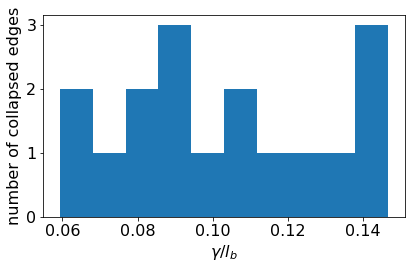

In [10]:
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

e_col = np.loadtxt("nbrun/edges_collapse.txt")
l_i = np.loadtxt("nbrun/edges_lengths.txt")
e_gamma = np.loadtxt("nbrun/edges_tensions.txt")
idxs= np.where(e_col<0.1)
#print(len(idxs[0]))
e_closed = idxs[0]
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

ra = e_gamma/l_i
# We can set the number of bins with the `bins` kwarg
axs.hist(ra[e_closed])#, bins=n_bins)
axs.set_xlabel("$\gamma/l_b$")
axs.set_ylabel("number of collapsed edges")
#axs[1].hist(e_gamma[e_closed])#, bins=n_bins)
#axs[1].set_xlabel("$\gamma_b$")
#axs[1].set_ylabel("number of collapsed edges")

plt.savefig("nbrun/edge_collapse_hist3.pdf")
plt.show()

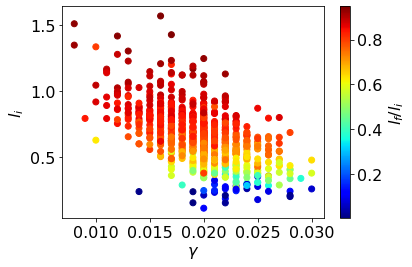

In [11]:
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

e_col = np.loadtxt("nbrun/edges_collapse.txt")
l_i = np.loadtxt("nbrun/edges_lengths.txt")
e_gamma = np.loadtxt("nbrun/edges_tensions.txt")

sc = plt.scatter(e_gamma, l_i, c=e_col, cmap='jet')
plt.xlabel("$\gamma$")
plt.ylabel("$l_i$")
plt.colorbar(sc, label='$l_f/l_i$', cmap='jet')
plt.tight_layout()
plt.savefig("collapse_phase2.pdf")
# idxs= np.where(e_col<0.1)
# e_closed = idxs[0]

# idxs= np.where(e_col>=0.1 and e_col<=0.5)
# e_shrinked = idxs[0]

# idxs= np.where(e_col>0.5)
# e_notshrinked = idxs[0]
#plt.plot(e_gamma[e_col<0.1], e_col[e_col<0.1], 'r^')
#plt.plot(e_gamma[(e_col>=0.1)&(e_col<0.5)], e_col[(e_col>=0.1)&(e_col<0.5)], 'ks')

### For only the visualization of pre-simulated data, run the next cell

In [6]:
from Tissue_Objects import *
from CommonOperations import *
write_freq = 100
color_type = 'd2W_dv2'
visulaise_frames(n_steps, write_freq, color_type)

### If we want to see how energy decays over time steps of simulation, run the next cell:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


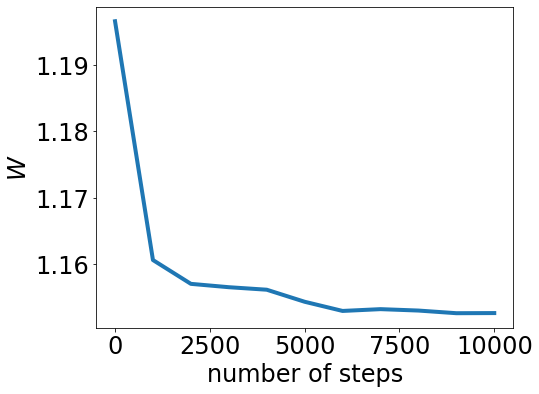

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24
       }

fig, ax = plt.subplots(1,1,figsize=(8,6))

plt.rc('font', **font)
steps = np.arange(0,n_steps+1,write_freq)
ax.plot(steps, W_steps, linewidth=4)
ax.set_xlabel('number of steps')
ax.set_ylabel('$W$')
plt.tight_layout()
plt.savefig('minimization_steps_gamma'+str(gamma)+'.pdf')
plt.show()

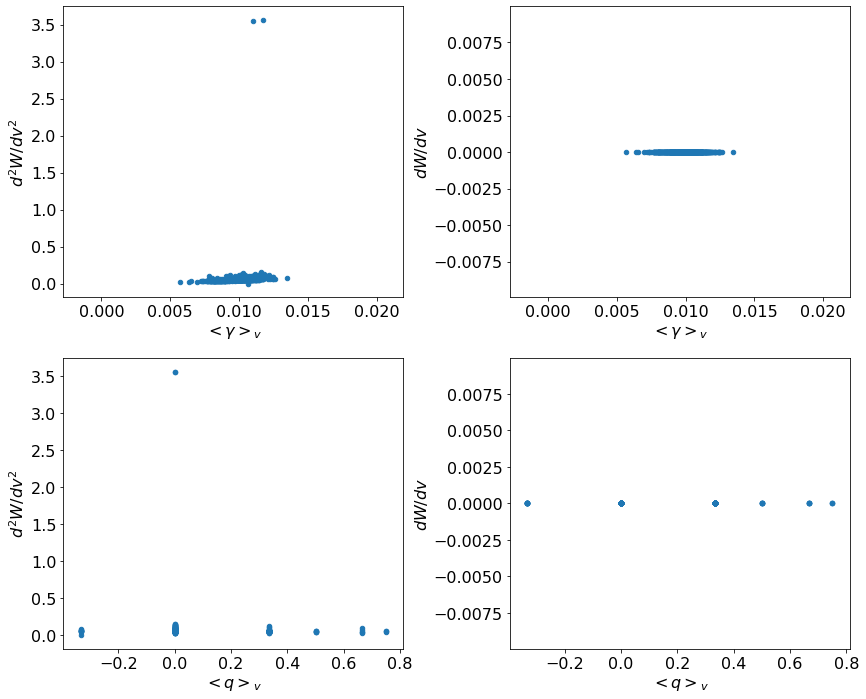

In [7]:
d2w_dh2 = [v.d2W_dh2 for v in T.ListVertex]
dw_dh = [v.Norm_dW_dh for v in T.ListVertex]
gamma_avg = []
q_avg = []
for v in T.ListVertex:
    gammas = [e.lineTension for e in v.connectedEdges]
    gamma_avg.append(np.mean(gammas))
    polycharges = [6-len(cor.c.ListEdges) for cor in v.ListCorners]
    q_avg.append(np.mean(polycharges))
    
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16
       }

fig, axes = plt.subplots(2,2,figsize=(12,10))

plt.rc('font', **font)

v_area = 20
ax = axes.flat[0]
ax.scatter(gamma_avg, d2w_dh2, s=v_area)#, c=colors)#, alpha=0.0)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('$<{\gamma}>_v$')
ax.set_ylabel('$d^2W/dv^2$')

ax = axes.flat[1]
ax.scatter(gamma_avg, dw_dh, s=v_area)#, c=colors)#, alpha=0.0)
ax.set_xlabel('$<\gamma>_v$')
ax.set_ylabel('$dW/dv$')

ax = axes.flat[2]
ax.scatter(q_avg, d2w_dh2, s=v_area)#, c=colors)#, alpha=0.0)
ax.set_xlabel('$<q>_v$')
ax.set_ylabel('$d^2W/dv^2$')

ax = axes.flat[3]
ax.scatter(q_avg, dw_dh, s=v_area)#, c=colors)#, alpha=0.0)
ax.set_xlabel('$<q>_v$')
ax.set_ylabel('$dW/dv$')

plt.tight_layout()
plt.savefig('probing_vertex_'+str(Ta)+'.pdf')
plt.show()

In [1]:
Ta=0.002
from CommonOperations import *
from matplotlib import colors as mcolors
datafile = '/Users/aamiri/Documents/research/projects/vertexModeling/python_VModel_v2/data/T10000.json'
image_name = 'gamma'+str(Ta)+'d2w_dv2.pdf'
color_type = 'd2W_dv2'
visualize_frame_jsonfile(datafile, image_name, color_type)

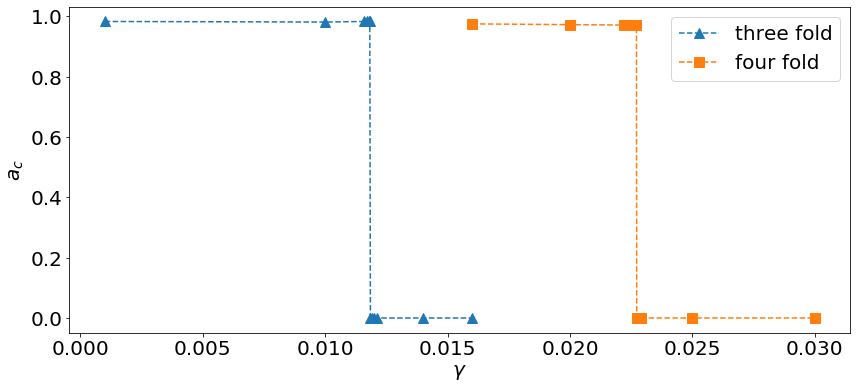

In [10]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
#matplotlib.rc('text', usetex=True)


threefold = ['0.0100', '0.0116', '0.0117', '0.0118', '0.011825', '0.01185', '0.0119', '0.0120', '0.0121']
fourfold = ['0.020', '0.0222', '0.0223', '0.0224', '0.0225', '0.0226', '0.0227', 
            '0.0227125', '0.022725', '0.02275', '0.0228', '0.0229' ]
base_folder = '/Users/aamiri/Desktop/Amin/vertexModel/'
# for three fold
Ac_three = [0.983]
Ta_three = [0.001]
for threefolder in threefold:
    datafile = base_folder + 'threefold/' + threefolder + '/data/T49950.json'
    Ta_three.append(float(threefolder))
    with open(datafile, 'r') as fp:
        data = json.load(fp)
        area_cells = data["cell_area"]
        Ac_three.append(area_cells[-1])
        
Ac_three.append(0.0)
Ta_three.append(0.014)
Ac_three.append(0.0)
Ta_three.append(0.016)

Ac_four = [0.975]
Ta_four = [0.016]
for fourfolder in fourfold:
    datafile = base_folder + 'fourfold/' + fourfolder + '/data/T49950.json'
    Ta_four.append(float(fourfolder))
    with open(datafile, 'r') as fp:
        data = json.load(fp)
        area_cells = data["cell_area"]
        Ac_four.append(area_cells[-1])
        
Ac_four.append(0)
Ta_four.append(0.025)
Ac_four.append(0)
Ta_four.append(0.03)
        
# plot the data
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Ta_three, Ac_three, '^--', markersize=10, label='three fold')
ax.plot(Ta_four, Ac_four, 's--', markersize=10, label='four fold')
plt.ylabel('$a_c$')
plt.xlabel('$\gamma$')
plt.legend()
plt.savefig('together.pdf')
plt.show()
#plt.plot(Ta_three, Ac_three, '.')
#plt.show()